# 001_examplesUsingMAF #

For the LSST:UK Bulge working group meeting, 2017-05-12 in Preston, UK. Some examples using **sims_maf** to query simulated LSST 10-year surveys in order to assess candidate strategies. I've focused on a few of the pieces that may be particuarly relevant to LSST-Bulge science, which as a special survey seems to suffer from some peculiarities of the way the baseline survey is currently scheduled. 

This notebook is mainly intended as a quick overview to provoke thinking. To really get to grips with sims_maf properly, I suggest starting with the excellent set of tutorials here:
https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/Index.ipynb

### Examples shown in *this* notebook: ###

1. Visualising the number of visits to each location;
2. Selecting metric regions spatially (e.g. for the bulge subregion);
3. Visualising the time-series of visits to two pointings (in- and out-of-bulge); 

This notebook gathers pieces from a number of tutorial notebooks throughout sims_maf and on my own informal scratch repository. The two most relevant are probably:

Selecting metric regions spatially: https://github.com/willclarkson/lsstScratchWIC/blob/master/notebooks/TrySelectingMetricSpatially.ipynb

Plotting the "lightcurves" of visits to a particular pointing:
https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/PullLightCurves.ipynb


**History**

**2017-05-12:** Started; initial three examples culled from various tutorial sites.

# 0. Setting up #

### Before starting: ensure the environment is set up for maf ###

On my system, this means doing the following from the terminal (before launching the notebook):

source ~/Soft/lsst/loadLSST.csh

setup sims_maf -t sims

setup sims_maf_contrib -t $USER -t sims

Then launch the notebook:

jupyter notebook

### Import the various pieces we'll need ###

In [1]:
# magic command when plotting from IPython/Jupyter notebook ##
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [210]:
import os, time, copy

In [53]:
# Now the LSST-specific pieces. Import may take a few seconds to complete.
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots


In [9]:
# more LSST-specific stuff... This time for stellar density maps
import lsst.sims.maf.maps as maps

In [107]:
# useful for co-ordinate conversions
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic
import astropy.units as u

In [205]:
import healpyUtils

ERROR: ImportError: No module named healpyUtils [IPython.core.interactiveshell]


ImportError: No module named healpyUtils

In [206]:
# If the above call produces an error, copy file sims_utils/python/lsst/sims/utils/healpyUtils.py into 
# the working directory, e.g.
! cp -p /Users/clarkson/anaconda/opt/lsst/sims_utils/python/lsst/sims/utils/healpyUtils.py .

In [207]:
import healpyUtils

### Ensure the OpSim databases are available ###

In [4]:
# It's easiest to symlink the large db file to the current directory:
! pwd
! ls -rtlh *db

/Users/clarkson/Data/LSST/testNotebooks
ls: *db: No such file or directory


OK it looks like we don't have the .db files to hand yet. Since they're large, symlink them in:

In [5]:
! ln -s /Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/minion_1016_sqlite.db .
! ln -s /Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/astro_lsst_01_1004_sqlite.db .
! ls -rtlh *db

lrwxr-xr-x  1 clarkson  staff    71B May 12 14:54 minion_1016_sqlite.db -> /Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/minion_1016_sqlite.db
lrwxr-xr-x  1 clarkson  staff    78B May 12 14:54 astro_lsst_01_1004_sqlite.db -> /Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/astro_lsst_01_1004_sqlite.db


### Set various input/output variables###

In [6]:
# (Note Jupyter notebook should auto-complete the filename if it's in the 
# current working directory)
dbFile='minion_1016_sqlite.db'

In [11]:
outDirNVis = 'nvisitsMap'

# 1. Visualising the number of visits to each location #

**Note:** the general sequence of steps is usually the same, so they are spelled out here. Connect to database --> define metrics --> set up slicer --> set sql filter --> assemble metrics into "bundles" and the bundles into a "bundle group" --> run all --> plot.

### Connect to the database, set up output database and directory ###

In [14]:
opsdb = db.OpsimDatabase(dbFile)
resultsDb = db.ResultsDb(outDir=outDirNVis)

### Define the metrics which will be applied to the database ###

In [24]:
# ("Count" metric can use any column, the CountMetric just counts up the number of instances)
metricNVis = metrics.CountMetric(col='fieldRA', metricName='Count')

# Let's also see the co-added M5 depth, assuming no spatial confusion:
metricM5 = metrics.Coaddm5Metric()

### Set the 'slicer' that will organize the metric values ###

In this case we go with a healpix slicer to see the spatial variation of the values. 
NSIDE sets the spatial resolution (the larger the number, the finer the resolution).

In [25]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Decide how to select entries in the observations database ###

In [72]:
sqlRband = 'filter = "r" and night < 10000'

### Assemble the database, metrics, sql selection, slicer and I/O directories into a metric 'bundle group'  ###

In [73]:
# Note that the metrics do not by default run summary statistics. Let's ensure that happens.
summaryMetrics = [metrics.MinMetric(), metrics.MeanMetric(), metrics.MaxMetric(), 
                  metrics.MedianMetric(), metrics.RmsMetric(), 
                 metrics.PercentileMetric(percentile=25), metrics.PercentileMetric(percentile=75)]

In [74]:
# The metrics are gathered into a dictionary...
bundles = {}

bundles['count'] = metricBundles.MetricBundle(metricNVis, slicer, sqlRband, summaryMetrics=summaryMetrics)
bundles['coaddM5'] = metricBundles.MetricBundle(metricM5, slicer, sqlRband, summaryMetrics=summaryMetrics)

# ... which are then used to construct a "metric bundle group" which we will later run
# and plot:
bgroup = metricBundles.MetricBundleGroup(bundles,opsdb, outDir=outDirNVis, resultsDb=resultsDb)

### ... run and plot the results ### 

In [75]:
bgroup.runAll()

Querying database with constraint filter = "r" and night < 10000
Found 538713 visits
Running:  ['count', 'coaddM5']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Some notes on the resulting structure ###

It can be useful to examine the structure of the result (e.g. to set plot parameters).
The "bundle group" has an object "bundleDict", which is a python dictionary consisting of one 
entry per "bundle". Each bundle has its own methods and attributes (I find the "metricValues" attribute the most useful - it contains the actual metrics for each location). For example, in this case we have one "bundleDict" each for the "counts" and "M5" metrics we just ran:

In [76]:
# Take a look at the object
print bgroup.bundleDict.keys()

['count', 'coaddM5']


In [77]:
# I find it helpful to create a view of the metric we just ran, so that inline help becomes
# available:
dum = bgroup.bundleDict['count']

# uncomment the line below to see more on the structure of the resulting object.
# help(dum)  

In [90]:
# ... We can now adjust plot limits without having to re-run the metric query.
bgroup.bundleDict['count'].plotDict['xMax'] = 450.
bgroup.bundleDict['count'].plotDict['colorMax'] = 450.
bgroup.bundleDict['count'].plotDict['cmap'] = plt.cm.get_cmap('RdBu_r')

bgroup.bundleDict['coaddM5'].plotDict = {} # set to defaults
bgroup.bundleDict['coaddM5'].plotDict['xMin'] = 24.
bgroup.bundleDict['coaddM5'].plotDict['xMax'] = 29.

In [91]:
# Let's suppress all but the spatial map for the count metric
bgroup.bundleDict['count'].plotFuncs = [plots.HealpixSkyMap()]
print dum.plotFuncs

Plotting figures with "filter = "r" and night < 10000" constraint now.
Plotting complete.


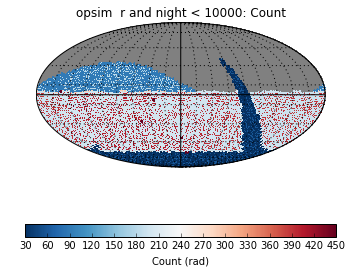

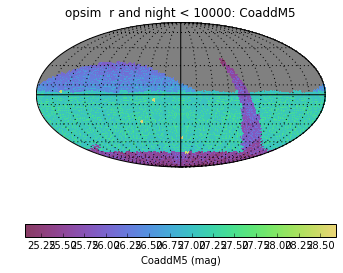

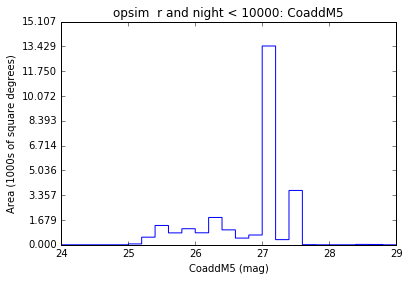

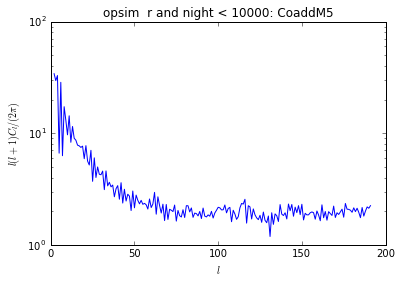

In [92]:
bgroup.plotAll(closefigs=False)

In [81]:
# that's a little tough to see... Let's look at the summary values:
bundleM5 = bgroup.bundleDict['coaddM5']

In [82]:
# Which did we run? (Usually  more or less transparently named)
bundleM5.summaryMetrics

In [89]:
# What were the values?
for mKey in bgroup.bundleDict.keys():
    print "-----------"
    print "%s:" % (mKey)
    print bgroup.bundleDict[mKey].summaryValues

-----------
count:
{'25th%ile': 92.0, 'Rms': 193.41834929229654, '75th%ile': 202.0, 'Min': 30.0, 'Max': 4289.0, 'Median': 198.0, 'Mean': 198.54447872477184}
-----------
coaddM5:
{'25th%ile': 26.41458918666973, 'Rms': 0.59739030742577959, '75th%ile': 27.11420695020529, 'Min': 25.060873512510863, 'Max': 28.687665647277051, 'Median': 27.067325714389717, 'Mean': 26.812770455787398}


## 2. Selecting spatially ##

For special surveys like the bulge, we really want to be able to select regions of interest. I haven't been able to find this feature in sims_maf, so use a trick to do spatial selection: 

1. Parameterize the region of interest as a decision boundary for which of the field centers are inside the ROI;

2. Generate co-ordinates of field centers using the same HEALPIX tesselation as was used in the slicer to build the metric;

3. Construct a boolean array determining which field centers fell within the ROI;

4. Use this boolean either on the metric values themselves, or assign it as a mask in the evaluated metric (e.g. for plotting).

First the method that generates the avoidance boundaries:

In [191]:
def getAvoidanceLatitudes(galL, peakDeg=10., taperDeg=80., constWidth=5.):
    
    """Returns the (positive) GP avoidance region for input galactic longitude"""
    
    # The following is adapted from spatialPlotters.py in sims_maf, method _plot_mwZone
    
    # astropy uses 0 <= glon <= 2pi, so we shift the input values accordingly.
    galL_use = np.copy(galL)
    gSec = np.where(galL_use > np.pi)
    galL_use[gSec] -= 2.0 * np.pi
    
    peakWidth=np.radians(peakDeg)
    taperLength=np.radians(taperDeg)
    val = peakWidth * np.cos(galL_use / taperLength * np.pi / 2.)
    
    # Remove the cosine peak at anticenter
    gFar = np.where(np.abs(galL_use) > taperLength)[0]
    val[gFar] = 0.

    val += np.radians(constWidth)
    
    return val

In [195]:
# select out our ['count'] metric
bCount = bgroup.bundleDict['count']

In [208]:
# We generate a set of co-ordinates from the healpix used to make the metric in the first place:
npix = bCount.metricValues.size
nside = hp.npix2nside(npix)
print "N pixels=%i - healpix NSIDE=%i" % (npix, nside)

ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

N pixels=49152 - healpix NSIDE=64


In [209]:
# OK now generate indices for objects inside the bulge "zone of avoidance"
r2deg = 180./np.pi
gLon = np.asarray(cc.galactic.l)
gLat = np.asarray(cc.galactic.b)

latAvoidPos = getAvoidanceLatitudes(gLon*np.pi/180., constWidth=0.0, peakDeg=7.)
latAvoidPos *= r2deg

# Perform the selection
bPln = (gLat < latAvoidPos) & (gLat > 0.-latAvoidPos)

In [214]:
# Now we can access our boolean-selected objects directly, for example:
print "Mean NVisits (in r), *inside* avoidance-region: %.2f" % (np.average(bCount.metricValues[bPln]))
print "Mean NVisits (in r), *outside* avoidance-region: %.2f" % (np.average(bCount.metricValues[~bPln]))

Mean NVisits (in r), *inside* avoidance-region: 38.45
Mean NVisits (in r), *outside* avoidance-region: 128.82


In [216]:
# We can also mask out all the pointings NOT inside our region of interest. The following example
# copies our Counts metric to a new metric and sets the mask appropriately:
bCountMasked = copy.deepcopy(bCount)
bCountMasked.metricValues.mask[~bPln] = True

{'SkyMap': 1}

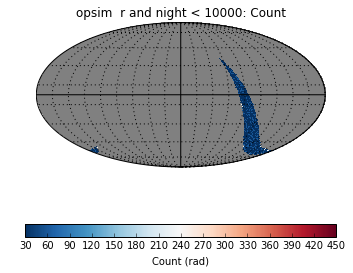

In [219]:
# Just to check... did this really select the points we want?
bCountMasked.plot(savefig=True)

... and indeed this does seem to have masked out all the points outside the inner Plane. Any statistics we compute from bCountMasked, will only include the points we care about.

## 3. Visualise visits to a particular pointing ##

In [117]:
# Change this to run for a different database...
dbFile = 'minion_1016_sqlite.db'  

In [118]:
outDirLCs = 'lightCurves_%s' % (os.path.splitext(dbFile)[0])

In [119]:
# filters, and colors to plot points at each filter when doing lightcurves
filters = ['u','g','r','i','z','y']
colors={'u':'cyan','g':'g','r':'y','i':'r','z':'m', 'y':'k'}

In [138]:
# locations on the sky to show the lightcurves...
gL = [0.,   20.]
gB = [0., -30.]

In [170]:
# Use astropy's SkyCoord to convert those into radians for the slicer
coo = SkyCoord(gL, gB, frame=Galactic, unit=u.deg)
raPointings = coo.icrs.ra.deg
dePointings = coo.icrs.dec.deg
print raPointings
print dePointings

[ 266.40498829  305.76377422]
[-28.93617776 -23.60825404]


In [172]:
# try them by hand
print np.radians(raPointings)
print np.radians(dePointings)

[ 4.64964419  5.33658459]
[-0.50503157 -0.41204176]


In [173]:
# connect to the database, set the output results
opsdb = db.OpsimDatabase(dbFile)
resultsDb = db.ResultsDb(outDir=outDirLCs)

Set up the metric bundles, one per pointing on the sky:

In [174]:
snrLimit = 5.  # at least this many points > SNR limit to plot LC
nPtsLimit = 6 # at least this many points to plot at all

metric = metrics.PassMetric(cols=['filter','fiveSigmaDepth','expMJD'])  # just pass the points through.
sql = 'night < 2500' # on my laptop, running without constraint takes ~45 minutes

bGroupDict = {}
for iCoo in range(len(raPointings)):
    ra = raPointings[iCoo]
    dec = dePointings[iCoo]
    
    print ra, dec 
    
    slicer = slicers.UserPointsSlicer(ra,dec,lonCol='ditheredRA',latCol='ditheredDec')
    bGroupDict[iCoo] = metricBundles.MetricBundle(metric,slicer,sql)

# turn this into a metric bundle group...
bg = metricBundles.MetricBundleGroup( bGroupDict, opsdb,
                                      outDir=outDirLCs, resultsDb=resultsDb)

266.404988287 -28.9361777618
305.763774217 -23.6082540434


In [175]:
# now run everything for all the pointings
t0 = time.time()
bg.runAll()
t1 = time.time()
print "Entire cell took %.2e seconds" % (t1-t0)

Querying database with constraint night < 2500
Found 1675458 visits
Running:  [0]
Completed metric generation.
Running:  [1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Entire cell took 8.16e+01 seconds


In [148]:
print bg.bundleDict.keys()

[0, 1]


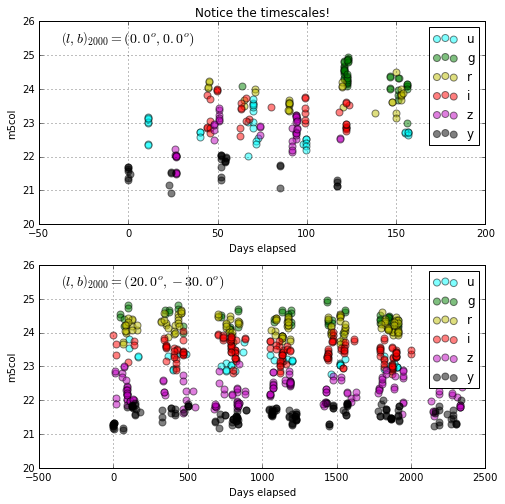

In [220]:
# Now show the results...
plt.figure(1, figsize=(8,8))
plt.clf()

# let's loop through the pointings
nPointings = len(bg.bundleDict.keys())
for iKey in range(nPointings):
    
    thisBundle = bg.bundleDict[iKey]
    dayZero = thisBundle.metricValues.data[0]['expMJD'].min()
    
    plt.subplot(nPointings, 1, iKey+1)
    
    # plot a lightcurve for each filter
    for fname in filters:
        good = np.where(thisBundle.metricValues.data[0]['filter'] == fname)
        plt.scatter(thisBundle.metricValues.data[0]['expMJD'][good]- dayZero, 
                    thisBundle.metricValues.data[0]['fiveSigmaDepth'][good],
                    c = colors[fname], label=fname, s=49, alpha=0.5)
        
    # Show the field
    sField = r"$\left( l, b \right)_{2000} = (%.1f^o, %.1f^o)$" % (gL[iKey], gB[iKey])
    plt.annotate(sField, (0.05,0.90), xycoords='axes fraction', fontsize=14)
    plt.legend()
    
    plt.xlabel('Days elapsed')
    plt.ylabel('m5col')
    
    plt.grid(which='both')
    
    if iKey < 1:
        plt.title('Notice the timescales!')
        
plt.savefig('./testM5timeseries.png')